In [1]:
from collections import Counter, defaultdict, deque
from functools import partial, lru_cache
from itertools import chain, cycle, product

import numpy as np

In [2]:
recipes = [
    {"A": 11, "B": 15, "C": 18, "D": 4, "E": 9, "F": 8},
    {"A": 16, "B": 10, "C": 8, "D": 4, "E": 4, "F": 8},
    {"A": 10, "B": 15, "C": 5, "D": 8},
    {"A": 10, "B": 12},
]
batch_sizes = [25, 50, 100]
sample_size = 20000
lane_lock = 25

In [3]:
# def batch_pattern(recipe):
#     products = np.array(list(recipe.keys()))
#     totals = np.array(list(recipe.values()))
    
# #     proportions = np.ceil(totals / np.min(totals)).astype(int)
#     proportions = np.floor(totals / np.min(totals)).astype(int)
    
#     remainders = np.remainder(totals, np.min(totals))
    
#     pattern = []
#     while 0 < np.sum(proportions):
#         for product_index, product, proportion in sorted(
#             zip(range(len(products)), products, proportions),
#             key=lambda x: x[2],
#             reverse=True
#         ):
#             if 0 < proportion:
#                 pattern.append(product)
#                 proportions[product_index] = proportion - 1
            

#     # repeat a certain number of times
#     out = []
#     for i in range(np.min(totals)):
#         out.extend(pattern)
#         for product_index, remainder in enumerate(remainders):
#             if 0 < remainder:
#                 out.append(products[product_index])
#                 remainders[product_index] = remainder - 1

#     return out

In [4]:
from math import gcd
from functools import reduce
import pprint

def batch_pattern(recipe, num_of_lanes, batch_size):
    products = np.array(list(recipe.keys()))
    totals = np.array(list(recipe.values()))
    
    divisor = np.gcd.reduce(totals)

    ratios = []
    
    for product in products:
        lane_size = recipe[product]
        queue_size = lane_size * num_of_lanes
        ratios.append([
            max(1, np.floor(queue_size/batch_size).astype(int)),
            np.ceil(queue_size/batch_size - max(1, np.floor(queue_size/batch_size))),
            lane_size,
            product,
        ])
    ratios = sorted(ratios, reverse=True)
    pprint.pprint(ratios)
    
    pattern = []
    main = True
    while 0 < sum(r[2] for r in ratios):
        for r in ratios:
            if main:
                if 0 < r[2]:
                    pattern.extend([r[-1]] * r[0])
                    r[2] -= r[0]
                else:
                    continue
            else:
                if 0 < r[2] and 0 < r[1]:
                    pattern.append(r[-1])
                    r[2] -= 1
                else:
                    continue
        
        if main:
            main = False
        else:
            main = True
    
    return pattern

In [5]:
pattern = batch_pattern(recipes[0], 5, 25)
pattern

[[3, 1.0, 18, 'C'],
 [3, 0.0, 15, 'B'],
 [2, 1.0, 11, 'A'],
 [1, 1.0, 9, 'E'],
 [1, 1.0, 8, 'F'],
 [1, -0.0, 4, 'D']]


['C',
 'C',
 'C',
 'B',
 'B',
 'B',
 'A',
 'A',
 'E',
 'F',
 'D',
 'C',
 'A',
 'E',
 'F',
 'C',
 'C',
 'C',
 'B',
 'B',
 'B',
 'A',
 'A',
 'E',
 'F',
 'D',
 'C',
 'A',
 'E',
 'F',
 'C',
 'C',
 'C',
 'B',
 'B',
 'B',
 'A',
 'A',
 'E',
 'F',
 'D',
 'C',
 'A',
 'E',
 'F',
 'C',
 'C',
 'C',
 'B',
 'B',
 'B',
 'A',
 'A',
 'E',
 'F',
 'D',
 'C',
 'E',
 'F',
 'C',
 'C',
 'C',
 'B',
 'B',
 'B',
 'E']

In [6]:
# batch_pattern(recipes[0], 5, 100)

In [7]:
for r in recipes:
    p = batch_pattern(r, 5, 25)
    print()
    print(sorted(r.items()))
    print(sorted(Counter(p).items()))

[[3, 1.0, 18, 'C'],
 [3, 0.0, 15, 'B'],
 [2, 1.0, 11, 'A'],
 [1, 1.0, 9, 'E'],
 [1, 1.0, 8, 'F'],
 [1, -0.0, 4, 'D']]

[('A', 11), ('B', 15), ('C', 18), ('D', 4), ('E', 9), ('F', 8)]
[('A', 11), ('B', 15), ('C', 19), ('D', 4), ('E', 9), ('F', 8)]
[[3, 1.0, 16, 'A'],
 [2, 0.0, 10, 'B'],
 [1, 1.0, 8, 'F'],
 [1, 1.0, 8, 'C'],
 [1, -0.0, 4, 'E'],
 [1, -0.0, 4, 'D']]

[('A', 16), ('B', 10), ('C', 8), ('D', 4), ('E', 4), ('F', 8)]
[('A', 16), ('B', 10), ('C', 8), ('D', 4), ('E', 4), ('F', 8)]
[[3, 0.0, 15, 'B'], [2, 0.0, 10, 'A'], [1, 1.0, 8, 'D'], [1, 0.0, 5, 'C']]

[('A', 10), ('B', 15), ('C', 5), ('D', 8)]
[('A', 10), ('B', 15), ('C', 5), ('D', 8)]
[[2, 1.0, 12, 'B'], [2, 0.0, 10, 'A']]

[('A', 10), ('B', 12)]
[('A', 10), ('B', 12)]


In [8]:
def generate_batches_weighted(batch_size, recipe, sample_size):
    products = list(recipe.keys())
    totals = list(recipe.values())
    sizes = (np.ceil(np.array(totals) / np.min(totals)) * batch_size).astype(int).tolist()
    iterators = [[product]*size for product, size in zip(products, sizes)]
    base = cycle(chain(*iterators))
    return list(dict(zip(range(sample_size), base)).values())

In [9]:
def generate_random_weighted(recipe, sample_size):
    products = list(recipe.keys())
    return np.random.choice(
        products,
        size=sample_size,
        p=[t / sum(recipe.values()) for t in recipe.values()],
    ).tolist()

In [10]:
# # consider lane with lowest index (index := lane number)
# def no_priority(lane_tuple, product=None):
    
#     if product is None:
#         raise RuntimeError("No product set")
    
#     return lane_tuple[0]

# # consider lane with largest total number of products
def sum_of_product_priority(lane_tuple, product=None, boxes=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return (sum(lane_tuple[1].values()), -boxes[lane_tuple[0]])

# # consider lane with largest product count e.g., largest number of As
# def product_count_priority(lane_tuple, product=None):
    
#     if product is None:
#         raise RuntimeError("No product set")
    
#     return lane_tuple[1][product]

# # consider largest product count first, then largest sum of all products second
# def double_priority(lane_tuple, product=None):
    
#     if product is None:
#         raise RuntimeError("No product set")
    
#     return (lane_tuple[1][product], sum(lane_tuple[1].values()))


# lane priority
def product_count_lane_utilization_priority(lane_tuple, product=None, boxes=None):
    
    if product is None or boxes is None:
        raise RuntimeError("Please provide product and lane state")
    
    # negative sign since we prioritize lanes with lowest utilization
    return (lane_tuple[1][product], -boxes[lane_tuple[0]])

In [11]:
sequences = {}
for (i, recipe), batch_size in product([(i, r) for i, r in enumerate(recipes)], batch_sizes):
    sequences[(i, "batches", batch_size)] = generate_batches_weighted(batch_size, recipe, sample_size)

for i, recipe in enumerate(recipes):
    sequences[(i, "random", None)] = generate_random_weighted(recipe, sample_size)

In [12]:
def queue_priority(product, lanes=None, recipe=None, batch_size=None):
    if lanes is None or recipe is None or batch_size is None:
        raise RuntimeError("Lanes must be supplied")
    
    missing = 0
    for lane in lanes.values():
        if lane["lock"] == 0:
            missing += recipe[product] - lane[product]
        
#     fits = int(batch_size <= missing)
    return missing

In [13]:
def simulate(
    sample_size,
    num_of_lanes,
    sequence_type,
    recipe_index,
    recipe,
    lane_lock,
    priority,
    batch_size=None,
    reverse=True
):    
    products = list(recipe.keys())  
    totals = list(recipe.values())
    batch_order = []
    lanes = {i: {p: 0 for p in products + ["lock"]} for i in range(num_of_lanes)}
    boxes = {i: 0 for i in range(num_of_lanes)}
    recirculation = []
    
    if sequence_type == "batches":
    
        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")
            
        sequence = sequences[(recipe_index, sequence_type, batch_size)]
    
    elif sequence_type == "random":
        
        sequence = sequences[(recipe_index, sequence_type, None)]
        
    elif sequence_type == "smart":
        
        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")
        
        x = max(
            products,
            key=partial(queue_priority, lanes=lanes, recipe=recipe, batch_size=batch_size)
        )
        sequence = [x] * batch_size
        batch_order.append(x)
        
    elif sequence_type == "smart_cycle":
        
        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")
    
        batch_pattern_iter = cycle(batch_pattern(recipe, num_of_lanes, batch_size))
        next_batch = next(batch_pattern_iter) 
        sequence = [next_batch] * batch_size
        batch_order.append(next_batch)
    
    else:
        raise RuntimeError(f"sequence_type {sequence_type} if unknown!")

    # init sequences
    product_queue = deque(sequence)
    
    product_counter = 0
    while product_counter < sample_size:

        product = product_queue.popleft()
        consumed = False
        for i, lane in sorted(lanes.items(), key=partial(priority, product=product, boxes=boxes), reverse=reverse):
            
            # Lane is available to accept products
            lane_is_available = lane["lock"] == 0
            
            # Lane has space to accept product
            product_fits = lane[product] < recipe[product]
            
            # Complete cases for 3 binary variables
            if not consumed and lane_is_available and product_fits:
                lane[product] += 1
                consumed = True
            
            elif not consumed and lane_is_available and not product_fits:
                continue
    
            elif not consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1
    
            elif not consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1
    
            elif consumed and lane_is_available and product_fits:
                continue
    
            elif consumed and lane_is_available and not product_fits:
                continue
    
            elif consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1
    
            elif consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1
                
        # recirculation un-consumed products
        if not consumed:
            recirculation.append(product)

        # Lane is ready to be boxed
        for j in lanes:
            if all(lanes[j][p] == recipe[p] for p in products):
                lanes[j] = {p: 0 for p in products + ["lock"]}
                lanes[j]["lock"] = lane_lock
                boxes[j] += 1
        
        # check if the queue is empty
        if len(product_queue) == 0 and sequence_type == "smart":
            x = max(
                products,
                key=partial(queue_priority, lanes=lanes, recipe=recipe, batch_size=batch_size)
            )
            product_queue.extend([x]*batch_size)
            batch_order.append(x)
        
        elif len(product_queue) == 0 and sequence_type == "smart_cycle":
            next_batch = next(batch_pattern_iter)
            product_queue.extend([next_batch] * batch_size)
            batch_order.append(next_batch)
        
        # continue onto the next product
        product_counter += 1
    
    return {
        "recirculation": len(recirculation), 
        "sample_size": sample_size,
        "box_products": sum(recipe.values()) * sum(boxes.values()),
        "unbox_products": sample_size - len(recirculation) - sum(recipe.values()) * sum(boxes.values()),
        "boxes_per_lane": dict(boxes),
        "boxes": sum(dict(boxes).values()),
        "batch_order": batch_order,
    }

In [14]:
simulate(sample_size, 5, "random", 0, recipes[0], lane_lock, sum_of_product_priority)

{'recirculation': 796,
 'sample_size': 20000,
 'box_products': 19110,
 'unbox_products': 94,
 'boxes_per_lane': {0: 59, 1: 59, 2: 59, 3: 59, 4: 58},
 'boxes': 294,
 'batch_order': []}

In [15]:
simulate(sample_size, 5, "batches", 0, recipes[0], lane_lock, sum_of_product_priority, batch_size=100)

{'recirculation': 15680,
 'sample_size': 20000,
 'box_products': 4225,
 'unbox_products': 95,
 'boxes_per_lane': {0: 13, 1: 13, 2: 13, 3: 13, 4: 13},
 'boxes': 65,
 'batch_order': []}

In [16]:
d = simulate(sample_size, 5, "smart", 0, recipes[0], lane_lock, sum_of_product_priority, batch_size=25)
print(d)
prop = sorted(Counter(d["batch_order"]).items())
print(prop)
[(k, v / min(v for k,v in prop)) for k,v in prop]

{'recirculation': 479, 'sample_size': 20000, 'box_products': 19500, 'unbox_products': 21, 'boxes_per_lane': {0: 60, 1: 60, 2: 60, 3: 60, 4: 60}, 'boxes': 300, 'batch_order': ['C', 'B', 'C', 'A', 'B', 'E', 'C', 'F', 'A', 'B', 'D', 'E', 'C', 'B', 'C', 'F', 'A', 'C', 'B', 'E', 'A', 'C', 'F', 'B', 'D', 'E', 'C', 'B', 'A', 'C', 'F', 'B', 'C', 'A', 'E', 'B', 'C', 'D', 'F', 'A', 'C', 'B', 'E', 'C', 'B', 'A', 'C', 'F', 'E', 'B', 'A', 'D', 'C', 'B', 'C', 'F', 'A', 'E', 'C', 'B', 'A', 'C', 'B', 'E', 'F', 'D', 'A', 'C', 'B', 'C', 'B', 'C', 'E', 'F', 'A', 'B', 'C', 'D', 'E', 'C', 'B', 'A', 'F', 'C', 'B', 'A', 'C', 'E', 'F', 'B', 'D', 'A', 'C', 'B', 'C', 'E', 'F', 'C', 'B', 'A', 'E', 'C', 'B', 'A', 'D', 'F', 'C', 'B', 'E', 'C', 'A', 'B', 'C', 'F', 'A', 'E', 'B', 'C', 'D', 'F', 'C', 'B', 'A', 'C', 'E', 'B', 'C', 'A', 'B', 'E', 'F', 'D', 'C', 'C', 'B', 'A', 'C', 'B', 'E', 'A', 'F', 'C', 'B', 'D', 'E', 'C', 'A', 'B', 'F', 'C', 'B', 'A', 'C', 'E', 'F', 'B', 'A', 'C', 'D', 'E', 'C', 'B', 'C', 'A', 'F', 

[('A', 2.2666666666666666),
 ('B', 3.0),
 ('C', 3.683333333333333),
 ('D', 1.0),
 ('E', 1.8),
 ('F', 1.6)]

In [17]:
dd = simulate(sample_size, 5, "smart_cycle", 0, recipes[0], lane_lock, sum_of_product_priority, batch_size=25)
print(dd)
prop = sorted(Counter(dd["batch_order"]).items())
print(prop)
[(k, v / min(v for k,v in prop)) for k,v in prop]

[[3, 1.0, 18, 'C'],
 [3, 0.0, 15, 'B'],
 [2, 1.0, 11, 'A'],
 [1, 1.0, 9, 'E'],
 [1, 1.0, 8, 'F'],
 [1, -0.0, 4, 'D']]
{'recirculation': 4115, 'sample_size': 20000, 'box_products': 15600, 'unbox_products': 285, 'boxes_per_lane': {0: 48, 1: 48, 2: 48, 3: 48, 4: 48}, 'boxes': 240, 'batch_order': ['C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 

[('A', 2.7916666666666665),
 ('B', 3.8125),
 ('C', 4.8125),
 ('D', 1.0),
 ('E', 2.2708333333333335),
 ('F', 2.0)]

In [18]:
list(zip(d["batch_order"], dd["batch_order"]))

[('C', 'C'),
 ('B', 'C'),
 ('C', 'C'),
 ('A', 'B'),
 ('B', 'B'),
 ('E', 'B'),
 ('C', 'A'),
 ('F', 'A'),
 ('A', 'E'),
 ('B', 'F'),
 ('D', 'D'),
 ('E', 'C'),
 ('C', 'A'),
 ('B', 'E'),
 ('C', 'F'),
 ('F', 'C'),
 ('A', 'C'),
 ('C', 'C'),
 ('B', 'B'),
 ('E', 'B'),
 ('A', 'B'),
 ('C', 'A'),
 ('F', 'A'),
 ('B', 'E'),
 ('D', 'F'),
 ('E', 'D'),
 ('C', 'C'),
 ('B', 'A'),
 ('A', 'E'),
 ('C', 'F'),
 ('F', 'C'),
 ('B', 'C'),
 ('C', 'C'),
 ('A', 'B'),
 ('E', 'B'),
 ('B', 'B'),
 ('C', 'A'),
 ('D', 'A'),
 ('F', 'E'),
 ('A', 'F'),
 ('C', 'D'),
 ('B', 'C'),
 ('E', 'A'),
 ('C', 'E'),
 ('B', 'F'),
 ('A', 'C'),
 ('C', 'C'),
 ('F', 'C'),
 ('E', 'B'),
 ('B', 'B'),
 ('A', 'B'),
 ('D', 'A'),
 ('C', 'A'),
 ('B', 'E'),
 ('C', 'F'),
 ('F', 'D'),
 ('A', 'C'),
 ('E', 'E'),
 ('C', 'F'),
 ('B', 'C'),
 ('A', 'C'),
 ('C', 'C'),
 ('B', 'B'),
 ('E', 'B'),
 ('F', 'B'),
 ('D', 'E'),
 ('A', 'C'),
 ('C', 'C'),
 ('B', 'C'),
 ('C', 'B'),
 ('B', 'B'),
 ('C', 'B'),
 ('E', 'A'),
 ('F', 'A'),
 ('A', 'E'),
 ('B', 'F'),
 ('C', 'D'),

In [47]:
from sklearn.metrics import homogeneity_score
import pprint

def score_batch_order(num_of_buckets, labels, print_buckets=False):
    buckets = [[] for _ in range(num_of_buckets)]

    for i, label in enumerate(labels):
        index = i % num_of_buckets
        buckets[index].append(label)

#     print(buckets)

    output = [labels[i:i + num_of_buckets] for i in range(0, len(labels), num_of_buckets)]
    for a in output:
        print()
        print(a)
        
#     import pdb; pdb.set_trace()
#     ground_truth = []
#     predicted = []
#     for b, bucket in enumerate(buckets):
#         most_frequent = max(set(bucket), key=bucket.count)
#         ground_truth.extend([most_frequent]*len(bucket))
#         predicted.extend(bucket)

#     seq = [ground_truth[0]]
#     for s in ground_truth[1:]:
#         if s != seq[-1]:
#             seq.append(s)
            
#     return num_of_buckets, homogeneity_score(ground_truth, predicted), seq, dict(Counter(seq))

In [50]:
score_batch_order(len(pattern), pattern)


['C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E']


In [51]:
score_batch_order(len(pattern), dd["batch_order"])


['C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E']

['C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E']

['C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E']

['C

In [52]:
score_batch_order(len(pattern), d["batch_order"])


['C', 'B', 'C', 'A', 'B', 'E', 'C', 'F', 'A', 'B', 'D', 'E', 'C', 'B', 'C', 'F', 'A', 'C', 'B', 'E', 'A', 'C', 'F', 'B', 'D', 'E', 'C', 'B', 'A', 'C', 'F', 'B', 'C', 'A', 'E', 'B', 'C', 'D', 'F', 'A', 'C', 'B', 'E', 'C', 'B', 'A', 'C', 'F', 'E', 'B', 'A', 'D', 'C', 'B', 'C', 'F', 'A', 'E', 'C', 'B', 'A', 'C', 'B', 'E', 'F', 'D']

['A', 'C', 'B', 'C', 'B', 'C', 'E', 'F', 'A', 'B', 'C', 'D', 'E', 'C', 'B', 'A', 'F', 'C', 'B', 'A', 'C', 'E', 'F', 'B', 'D', 'A', 'C', 'B', 'C', 'E', 'F', 'C', 'B', 'A', 'E', 'C', 'B', 'A', 'D', 'F', 'C', 'B', 'E', 'C', 'A', 'B', 'C', 'F', 'A', 'E', 'B', 'C', 'D', 'F', 'C', 'B', 'A', 'C', 'E', 'B', 'C', 'A', 'B', 'E', 'F', 'D']

['C', 'C', 'B', 'A', 'C', 'B', 'E', 'A', 'F', 'C', 'B', 'D', 'E', 'C', 'A', 'B', 'F', 'C', 'B', 'A', 'C', 'E', 'F', 'B', 'A', 'C', 'D', 'E', 'C', 'B', 'C', 'A', 'F', 'B', 'C', 'E', 'A', 'B', 'D', 'F', 'C', 'B', 'C', 'A', 'E', 'B', 'C', 'A', 'F', 'C', 'E', 'B', 'D', 'A', 'C', 'B', 'C', 'F', 'E', 'B', 'C', 'A', 'B', 'E', 'F', 'C']

['D

In [53]:
Counter(['C', 'B', 'C', 'A', 'B', 'E', 'C', 'F', 'A', 'B', 'D', 'E', 'C', 'B', 'C', 'F', 'A', 'C', 'B', 'E', 'A', 'C', 'F', 'B', 'D', 'E', 'C', 'B', 'A', 'C', 'F', 'B', 'C', 'A', 'E', 'B', 'C', 'D', 'F', 'A', 'C', 'B', 'E', 'C', 'B', 'A', 'C', 'F', 'E', 'B', 'A', 'D', 'C', 'B', 'C', 'F', 'A', 'E', 'C', 'B', 'A', 'C', 'B', 'E', 'F', 'D'])

Counter({'C': 18, 'B': 15, 'A': 11, 'E': 9, 'F': 8, 'D': 5})

In [54]:
Counter(['C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'A', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'A', 'A', 'E', 'F', 'D', 'C', 'E', 'F', 'C', 'C', 'C', 'B', 'B', 'B', 'E'])

Counter({'C': 19, 'B': 15, 'A': 11, 'E': 9, 'F': 8, 'D': 4})

In [55]:
def principal_period(s):
    i = (s+s).find(s, 1, -1)
    return None if i == -1 else s[:i]

In [64]:
def repeats(string):
    for x in range(1, len(string)):
        substring = string[:x]

        if substring * (len(string)//len(substring))+(substring[:len(string)%len(substring)]) == string:
            return substring

    return None

In [93]:
def longest_repeated_substring(str):

    n = len(str)
    LCSRe = [[0 for x in range(n + 1)] for y in range(n + 1)]

    res = ""  # To store result
    res_length = 0  # To store length of result

    # building table in bottom-up manner
    index = 0
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):

            # (j-i) > LCSRe[i-1][j-1] to remove
            # overlapping
            if str[i - 1] == str[j - 1] and LCSRe[i - 1][j - 1] < (j - i):
                LCSRe[i][j] = LCSRe[i - 1][j - 1] + 1

                # updating maximum length of the
                # substring and updating the finishing
                # index of the suffix
                if LCSRe[i][j] > res_length:
                    res_length = LCSRe[i][j]
                    index = max(i, index)

            else:
                LCSRe[i][j] = 0

    # If we have non-empty result, then insert
    # all characters from first character to
    # last character of string
    if res_length > 0:
        for i in range(index - res_length + 1, index + 1):
            res = res + str[i - 1]

    return res

In [94]:
s = "".join(dd["batch_order"])
print(len(s))
subs = repeats(s)
print(len(subs))
subs

801
66


'CCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBE'

In [95]:
longest_repeated_substring(s)

'CCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBECCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBECCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBECCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBECCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBECCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCAEFCCCBBBAAEFDCEFCCCBBBE'

In [96]:
s = "".join(d["batch_order"])
print(len(s))
subs = repeats(s)
print(len(subs))
subs

801
800


'CBCABECFABDECBCFACBEACFBDECBACFBCAEBCDFACBECBACFEBADCBCFAECBACBEFDACBCBCEFABCDECBAFCBACEFBDACBCEFCBAECBADFCBECABCFAEBCDFCBACEBCABEFDCCBACBEAFCBDECABFCBACEFBACDECBCAFBCEABDFCBCAEBCAFCEBDACBCFEBCABEFCDACBCBAECFBADECBCFACBEACFBDECBCAFBCAEBCDFCBAECBACFEBDACBCFECBACBEFADCBCABCEFABCDECBFACBCEAFBDCBCAEFCBAECBDFCABECBACFEBACDFCBCAEBCABEFDCCBACBEFACBDECBAFCBCAEFBCDACBECFBACEBADFCBCEACBFACEBDFCBCAEBCABEFCDACBCBEACFBDECABCFACBECFBADECBCAFBCEABCDFCBAECBCAFEBDCBCAFECBACBEFDACBCBACEFBACDECBFACBCEAFBDCBCEACFBAECBDFCBAECBCAFEBCDACBFECBACBEFADCCBACBEFACBDECBFACBCEAFBCDECBACFBACEBDFCABCEACBFCEBADFCBCAEBCABEFCDACBCBECFABDECBCAFECBACFBDACBECFBACEBACDFCBEACBCFAEBDCBCAFECBACBEFDACBCBCEAFBCDEACBFCBACEFBADCBCEACFBEACBDFCBAECBCAFEBCDACBFECBACBEFDACCBCBAEFCBADECBFCABCEAFBCDECBACFBCAEBDFCBCAEBCAFCEBDACBCFEBACBEFACDA'

In [97]:
ss = longest_repeated_substring(s)
ss

'CBDFCBAECBCAFEBCDACBFECBACBEF'

In [98]:
s.count(ss)

2

In [99]:
s = "repeater"
print(len(s))
subs = repeats(s)
print(len(subs))
subs

8
7


'repeate'

In [86]:
len(pattern)

66

In [87]:
sum(recipes[0].values())

65

In [56]:
patterns = []
for n in range(5, 100):
    patterns.append(score_batch_order(n, dd["batch_order"]))
    
for p in sorted(patterns, key=lambda x: x[1], reverse=True)[:5]:
    pprint.pprint(p)
    print(recipes[0])

[['C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'E', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'C', 'B', 'B', 'E', 'E', 'B', 'E', 'E', 'B', 'E', 'E', 'B', 'E', 'F', 'B', 'C', 'A', 'A', 'C', 'A', 'A', 'C', 'A', 'A', 'C', 'A', 'E', 'B', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'E', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'C', 'B', 'B', 'E', 'E', 'B', 'E', 'E', 'B', 'E', 'E', 'B', 'E', 'F', 'B', 'C', 'A', 'A', 'C', 'A', 'A', 'C', 'A', 'A', 'C', 'A', 'E', 'B', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'E', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'C', 'B', 'B', 'E'], ['C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'B', 'D', 'C', 'E', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', 'F', 'B', 'F', '

BdbQuit: 

In [23]:
def get_the_ys(xx, sequence_type, recipe_index, recipe, batch_size):
    yy = []
    for x in xx:
        data = simulate(
            sample_size,
            x,
            sequence_type,
            recipe_index,
            recipe,
            lane_lock,
            sum_of_product_priority,
            batch_size=batch_size,
        )
#         yy.append((data["box_products"] + data["unbox_products"]) / data["sample_size"])
        yy.append(data["box_products"] / data["sample_size"])
    
    return yy

In [24]:
def recipe_inefficiency(recipe):
    totals = list(recipe.values())
    consumption = np.array(totals) / np.min(totals)
    production = np.ceil(np.array(totals) / np.min(totals))
    return np.sum(production - consumption) / np.sum(production)

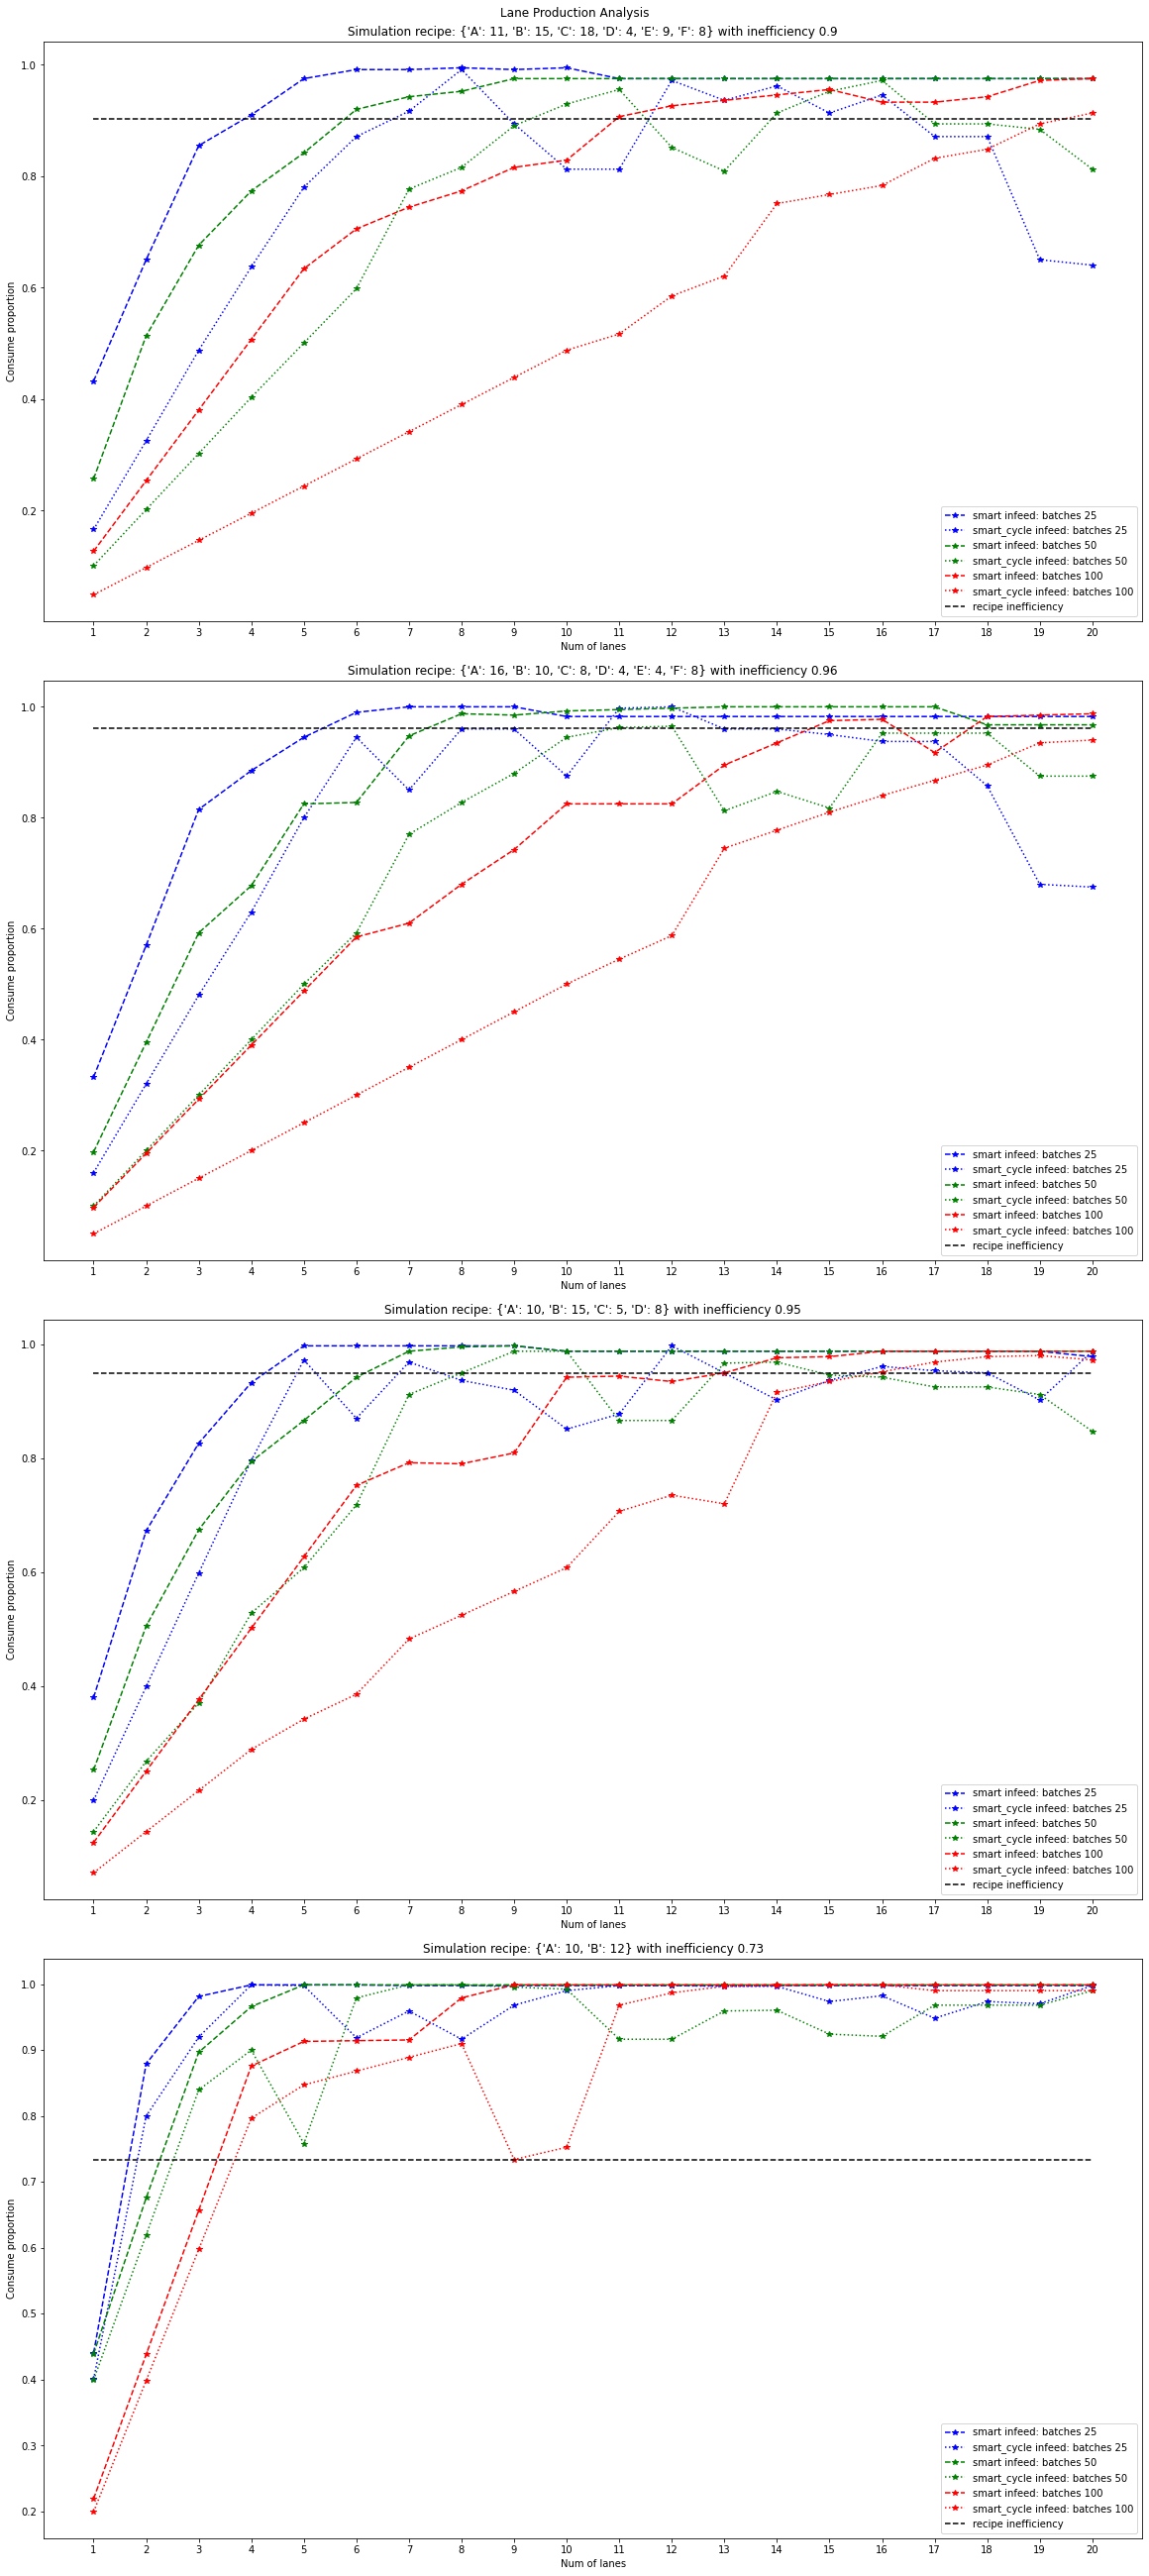

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axs = plt.subplots(len(recipes), figsize=(16, 9*len(recipes)), constrained_layout=True)

fig.suptitle("Lane Production Analysis")

for recipe_index, recipe in enumerate(recipes):
    
    color_index = 0
    xx = list(range(1, 21)) #+ list(range(20, 100, 10))
    for (index, sequence_type, batch_size) in sequences.keys():
        
        if recipe_index != index:
            continue
            
        color = list(mcolors.BASE_COLORS.items())[color_index][0]
        color_index += 1
        # normal
#         yy = get_the_ys(xx, sequence_type, recipe_index, recipe, batch_size)
#         axs[recipe_index].plot(xx, yy, f"-{color}", marker="*", label=f"sequencial infeed: {sequence_type} {batch_size}")
        
        # smart
        if sequence_type != "random":
            yy = get_the_ys(xx, "smart", recipe_index, recipe, batch_size)
            axs[recipe_index].plot(xx, yy, f"--{color}", marker="*", label=f"smart infeed: batches {batch_size}")
        
            yy = get_the_ys(xx, "smart_cycle", recipe_index, recipe, batch_size)
            axs[recipe_index].plot(xx, yy, f":{color}", marker="*", label=f"smart_cycle infeed: batches {batch_size}")

    zz = np.ones(len(xx)) * (1-recipe_inefficiency(recipe))
    axs[recipe_index].plot(xx, zz, f"--k", label=f"recipe inefficiency")
    axs[recipe_index].set_xticks(xx)
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe} with inefficiency {round(zz[0], 2)}")
    axs[recipe_index].set_xlabel("Num of lanes")
    axs[recipe_index].set_ylabel("Consume proportion")
plt.show()

In [26]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# fig, axs = plt.subplots(len(recipes), figsize=(16, 9*len(recipes)), constrained_layout=True)

# fig.suptitle("Lane Production Analysis")

# for recipe_index, recipe in enumerate(recipes):
    
#     color_index = 0
#     xx = list(range(1, 21)) #+ list(range(20, 100, 10))
#     for (index, sequence_type, batch_size) in sequences.keys():
        
#         if recipe_index != index:
#             continue
            
#         color = list(mcolors.BASE_COLORS.items())[color_index][0]
#         color_index += 1
#         # normal
#         yy = get_the_ys(xx, sequence_type, recipe_index, recipe, batch_size)
#         axs[recipe_index].plot(xx, yy, f"-{color}", marker="*", label=f"sequencial infeed: {sequence_type} {batch_size}")
        
#         # smart
#         if sequence_type != "random":
#             yy = get_the_ys(xx, "smart", recipe_index, recipe, batch_size)
#             axs[recipe_index].plot(xx, yy, f"--{color}", marker="*", label=f"smart infeed: batches {batch_size}")
    
#     zz = np.ones(len(xx)) * (1-recipe_inefficiency(recipe))
#     axs[recipe_index].plot(xx, zz, f"--k", label=f"recipe inefficiency")
#     axs[recipe_index].set_xticks(xx)
#     axs[recipe_index].legend()
#     axs[recipe_index].set_title(f"Simulation recipe: {recipe} with inefficiency {round(zz[0], 2)}")
#     axs[recipe_index].set_xlabel("Num of lanes")
#     axs[recipe_index].set_ylabel("Consume proportion")
# plt.show()